In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 23:07:48--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: 'CreditScoring.csv.1'

     0K .......... .......... .......... .......... .......... 28%  925K 0s
    50K .......... .......... .......... .......... .......... 56%  891K 0s
   100K .......... .......... .......... .......... .......... 84% 1,37M 0s
   150K .......... .......... ........                        100% 1,74M=0,2s

2021-10-03 23:07:49 (1,08 MB/s) - 'CreditScoring.csv.1' saved [182489/182489]



In [6]:
# read the data and make all columns names lowercase
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [7]:
# decode the features that are encoded as numbers
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [8]:
# prepare the numerical values
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [9]:
# remove clients with unknown default status
df = df[df.status != 'unk'].reset_index(drop=True)

In [10]:
# create the target variable
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [11]:
# split the data
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

In [12]:
# determine the categorical and numerical features
categorical = ['home', 'marital', 'records', 'job']
numerical = ['seniority','time','age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

## Question 1

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
# calculate roc auc for each numerical variable & target variable
scores = []

for feature in numerical:
    score = roc_auc_score(y_train, df_train[feature])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[feature])
    print(feature, score)
    scores.append(score)

seniority 0.7093778624491943
time 0.5608662489595051
age 0.5732933272499939
expenses 0.5009184217217011
income 0.682006666132633
assets 0.6486042567122802
debt 0.5047829675783548
amount 0.5910773431595518
price 0.5043329862114843


In [15]:
# train the model using only the columns specified in usecols
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse = False)

usecols = ['seniority', 'income', 'assets', 'records', 'job', 'home']
train_dict = df_train[usecols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model =  LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

In [16]:
# find the AUC of the model on the validation dataset
val_dict = df_val[usecols].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]

roc_auc_score(y_val, y_pred).round(3)

0.812

## Question 3

In [48]:
# calculate precision and recall of the model
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [50]:
columns = ['threshhold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

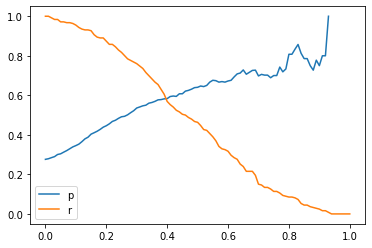

In [51]:
# plot both precision and recall
plt.plot(df_scores.threshhold, df_scores.precision, label = 'p')
plt.plot(df_scores.threshhold, df_scores.recall, label = 'r')
plt.legend()

## Question 4

In [64]:
# compute F1 score for all thresholds
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshhold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [72]:
# find the max f1
df_scores.sort_values(by='f1', ascending=False)

,threshhold,tp,fp,fn,tn,precision,recall,f1
30,0.30,187,162,59,483,0.535817,0.760163,0.628571
31,0.31,184,156,62,489,0.541176,0.747967,0.627986
32,0.32,181,150,65,495,0.546828,0.735772,0.627383
34,0.34,172,135,74,510,0.560261,0.699187,0.622061
33,0.33,176,144,70,501,0.550000,0.715447,0.621908
...,...,...,...,...,...,...,...,...
96,0.96,0,0,246,645,NaN,0.000000,NaN
97,0.97,0,0,246,645,NaN,0.000000,NaN
98,0.98,0,0,246,645,NaN,0.000000,NaN
99,0.99,0,0,246,645,NaN,0.000000,NaN


## Question 5

In [73]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [81]:
def train(df_train, y_train, C=0.1):
    dicts = df_train[categorical + numerical].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model =  LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = 'records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [82]:
# using the Kfold class for cross validation of the model 
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s +- %.3f' % (C, np.std(scores)))

C=10 +- 0.017


## Question 6

In [83]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.default.values
        y_val = df_val.default.values
        
        dv,model= train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.835 +- 0.021
C=0.1 0.843 +- 0.017
C=1 0.844 +- 0.017
C=10 0.843 +- 0.016
